# Import Libraries

In [4]:
import boto3, os
import botocore
import pandas as pd
import re

# Read in credentials file
This is a .txt file where I copy the access keys that are provided for me in the Account Details part of AWS classroom. This has not be included in our github repo in order to keep my keys private. The file is read in and the proper information is parsed out and used to connect to AWS Command Line Interface (CLI).


![my_image](images/Screen Shot 2020-04-14 at 2.04.12 PM.png)

In [5]:
key_list = []

with open('access_key', 'r') as file:
    for line in file:
        key_list.append(line.strip("\n"))

Parse relevant info

In [6]:
access_key_id = re.search('.*=(.*)', key_list[1]).group(1)
secret_access_key = re.search('.*=(.*)', key_list[2]).group(1)
session_token = re.search('.*=(.*=)', key_list[3]).group(1)

# Initialize boto3 client and resource with proper credentials

In [7]:
s3 = boto3.client('s3',
                aws_access_key_id=access_key_id,
                aws_secret_access_key=secret_access_key,
                aws_session_token=session_token,)
s3_resource = boto3.resource('s3',
                aws_access_key_id=access_key_id,
                aws_secret_access_key=secret_access_key,
                aws_session_token=session_token,)

# Create our S3 Bucket
This has been commented out because it only needed to be done once and will throw an error because all S3 buckets must have a unique name even accross users.

In [8]:
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket)
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket ' + bucket + ' could not be created.'
    return 'Created or already exists ' + bucket + ' bucket.'

In [9]:
create_bucket('taxinyc')

'Created or already exists taxinyc bucket.'

Check that Bucket was Created

In [10]:
response = s3.list_buckets()
response['Buckets']

[{'Name': 'taxinyc',
  'CreationDate': datetime.datetime(2020, 4, 26, 22, 46, 59, tzinfo=tzutc())},
 {'Name': 'unstructured',
  'CreationDate': datetime.datetime(2020, 4, 22, 15, 40, 28, tzinfo=tzutc())}]

# List Bucket Contents (files) in Registry of Open Data on AWS


In [11]:
def list_bucket_contents(bucket, match='', size_mb=0):
    bucket_resource = s3_resource.Bucket(bucket)
    total_size_gb = 0
    total_files = 0
    match_size_gb = 0
    match_files = 0
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        total_size_gb += key_size_mb
        total_files += 1
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True
        if list_check and not size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
        elif list_check and key_size_mb <= size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')

    if match:
        print(f'Matched file size is {match_size_gb/1024:3.1f}GB with {match_files} files')            
    
    print(f'Bucket {bucket} total size is {total_size_gb/1024:3.1f}GB with {total_files} files')

In [12]:
list_bucket_contents(bucket='nyc-tlc', match='2019')

trip data/fhv_tripdata_2019-01.csv (1242MB)
trip data/fhv_tripdata_2019-02.csv ( 93MB)
trip data/fhv_tripdata_2019-03.csv ( 72MB)
trip data/fhv_tripdata_2019-04.csv (104MB)
trip data/fhv_tripdata_2019-05.csv (111MB)
trip data/fhv_tripdata_2019-06.csv (107MB)
trip data/fhv_tripdata_2019-07.csv (103MB)
trip data/fhv_tripdata_2019-08.csv ( 99MB)
trip data/fhv_tripdata_2019-09.csv ( 56MB)
trip data/fhv_tripdata_2019-10.csv ( 98MB)
trip data/fhv_tripdata_2019-11.csv ( 88MB)
trip data/fhv_tripdata_2019-12.csv ( 95MB)
trip data/fhvhv_tripdata_2019-02.csv (1221MB)
trip data/fhvhv_tripdata_2019-03.csv (1444MB)
trip data/fhvhv_tripdata_2019-04.csv (1315MB)
trip data/fhvhv_tripdata_2019-05.csv (1351MB)
trip data/fhvhv_tripdata_2019-06.csv (1270MB)
trip data/fhvhv_tripdata_2019-07.csv (1228MB)
trip data/fhvhv_tripdata_2019-08.csv (1217MB)
trip data/fhvhv_tripdata_2019-09.csv (1214MB)
trip data/fhvhv_tripdata_2019-10.csv (1280MB)
trip data/fhvhv_tripdata_2019-11.csv (1308MB)
trip data/fhvhv_tripdat

![my_image2](images/Screen Shot 2020-04-21 at 1.13.37 PM.png)

Total cost of storing all of the 2019 data:

In [13]:
23.9 * 0.023 # $0.54 

0.5497

# Create function for saving a list of all the bucket names

In [14]:
def match_bucket_list(bucket, match='', size_mb=0):
    key_list = []
    bucket_resource = s3_resource.Bucket(bucket)
    
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True
        if list_check and not size_mb:
            key_list.append(key.key)
        elif list_check and key_size_mb <= size_mb:
            key_list.append(key.key)
    
    return key_list

In [15]:
key_list = match_bucket_list(bucket='nyc-tlc', match='2019')

# Seperate list into yellow and green taxi data

In [16]:
green_list = []
yellow_list = []

for i in key_list:
    if 'yellow' in i:
        yellow_list.append(i)
    if 'green' in i:
        green_list.append(i)

In [17]:
yellow_list

['trip data/yellow_tripdata_2019-01.csv',
 'trip data/yellow_tripdata_2019-02.csv',
 'trip data/yellow_tripdata_2019-03.csv',
 'trip data/yellow_tripdata_2019-04.csv',
 'trip data/yellow_tripdata_2019-05.csv',
 'trip data/yellow_tripdata_2019-06.csv',
 'trip data/yellow_tripdata_2019-07.csv',
 'trip data/yellow_tripdata_2019-08.csv',
 'trip data/yellow_tripdata_2019-09.csv',
 'trip data/yellow_tripdata_2019-10.csv',
 'trip data/yellow_tripdata_2019-11.csv',
 'trip data/yellow_tripdata_2019-12.csv']

In [18]:
green_list

['trip data/green_tripdata_2019-01.csv',
 'trip data/green_tripdata_2019-02.csv',
 'trip data/green_tripdata_2019-03.csv',
 'trip data/green_tripdata_2019-04.csv',
 'trip data/green_tripdata_2019-05.csv',
 'trip data/green_tripdata_2019-06.csv',
 'trip data/green_tripdata_2019-07.csv',
 'trip data/green_tripdata_2019-08.csv',
 'trip data/green_tripdata_2019-09.csv',
 'trip data/green_tripdata_2019-10.csv',
 'trip data/green_tripdata_2019-11.csv',
 'trip data/green_tripdata_2019-12.csv']

# Create functions for copying buckets

In [19]:
def key_exists(bucket, key):
    try:
        s3_resource.Object(bucket, key).load()
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            # The key does not exist.
            return(False)
        else:
            # Something else has gone wrong.
            raise
    else:
        # The key does exist.
        return(True)

def copy_among_buckets(from_bucket, from_key, to_bucket, to_key):
    if not key_exists(to_bucket, to_key):
        s3_resource.meta.client.copy({'Bucket': from_bucket, 'Key': from_key}, 
                                        to_bucket, to_key)        
        print(f'File {to_key} saved to S3 bucket {to_bucket}')
    else:
        print(f'File {to_key} already exists in S3 bucket {to_bucket}') 

In [20]:
for i in yellow_list:
    to_bucket_name = i.replace('trip data/', '')
    copy_among_buckets(from_bucket='nyc-tlc', from_key=i,
                       to_bucket='taxinyc', to_key="yellow2019/" + to_bucket_name)

File yellow2019/yellow_tripdata_2019-01.csv already exists in S3 bucket taxinyc
File yellow2019/yellow_tripdata_2019-02.csv already exists in S3 bucket taxinyc
File yellow2019/yellow_tripdata_2019-03.csv already exists in S3 bucket taxinyc
File yellow2019/yellow_tripdata_2019-04.csv already exists in S3 bucket taxinyc
File yellow2019/yellow_tripdata_2019-05.csv already exists in S3 bucket taxinyc
File yellow2019/yellow_tripdata_2019-06.csv already exists in S3 bucket taxinyc
File yellow2019/yellow_tripdata_2019-07.csv already exists in S3 bucket taxinyc
File yellow2019/yellow_tripdata_2019-08.csv already exists in S3 bucket taxinyc
File yellow2019/yellow_tripdata_2019-09.csv already exists in S3 bucket taxinyc
File yellow2019/yellow_tripdata_2019-10.csv already exists in S3 bucket taxinyc
File yellow2019/yellow_tripdata_2019-11.csv already exists in S3 bucket taxinyc
File yellow2019/yellow_tripdata_2019-12.csv already exists in S3 bucket taxinyc


In [21]:
for i in green_list:
    to_bucket_name = i.replace('trip data/', '')
    copy_among_buckets(from_bucket='nyc-tlc', from_key=i,
                       to_bucket='taxinyc', to_key="green2019/" + to_bucket_name)

File green2019/green_tripdata_2019-01.csv already exists in S3 bucket taxinyc
File green2019/green_tripdata_2019-02.csv already exists in S3 bucket taxinyc
File green2019/green_tripdata_2019-03.csv already exists in S3 bucket taxinyc
File green2019/green_tripdata_2019-04.csv already exists in S3 bucket taxinyc
File green2019/green_tripdata_2019-05.csv already exists in S3 bucket taxinyc
File green2019/green_tripdata_2019-06.csv already exists in S3 bucket taxinyc
File green2019/green_tripdata_2019-07.csv already exists in S3 bucket taxinyc
File green2019/green_tripdata_2019-08.csv already exists in S3 bucket taxinyc
File green2019/green_tripdata_2019-09.csv already exists in S3 bucket taxinyc
File green2019/green_tripdata_2019-10.csv already exists in S3 bucket taxinyc
File green2019/green_tripdata_2019-11.csv already exists in S3 bucket taxinyc
File green2019/green_tripdata_2019-12.csv already exists in S3 bucket taxinyc


In [22]:
def preview_csv_dataset(bucket, key, rows=10):
    data_source = {
            'Bucket': bucket,
            'Key': key
        }
    # Generate the URL to get Key from Bucket
    url = s3.generate_presigned_url(
        ClientMethod = 'get_object',
        Params = data_source
    )

    data = pd.read_csv(url, nrows=rows)
    return data

In [23]:
green01 = preview_csv_dataset(bucket='taxinyc', key='green2019/green_tripdata_2019-01.csv')
green02 = preview_csv_dataset(bucket='taxinyc', key='green2019/green_tripdata_2019-02.csv')
green03 = preview_csv_dataset(bucket='taxinyc', key='green2019/green_tripdata_2019-03.csv')
green04 = preview_csv_dataset(bucket='taxinyc', key='green2019/green_tripdata_2019-04.csv')
green05 = preview_csv_dataset(bucket='taxinyc', key='green2019/green_tripdata_2019-05.csv')
green06 = preview_csv_dataset(bucket='taxinyc', key='green2019/green_tripdata_2019-06.csv')
green07 = preview_csv_dataset(bucket='taxinyc', key='green2019/green_tripdata_2019-07.csv')
green08 = preview_csv_dataset(bucket='taxinyc', key='green2019/green_tripdata_2019-08.csv')
green09 = preview_csv_dataset(bucket='taxinyc', key='green2019/green_tripdata_2019-09.csv')
green10 = preview_csv_dataset(bucket='taxinyc', key='green2019/green_tripdata_2019-10.csv')
green11 = preview_csv_dataset(bucket='taxinyc', key='green2019/green_tripdata_2019-11.csv')
green12 = preview_csv_dataset(bucket='taxinyc', key='green2019/green_tripdata_2019-12.csv')

In [170]:
green = green01.append(green02)
green= green.append(green03)
green= green.append(green04)
green= green.append(green05)
green= green.append(green06)
green= green.append(green07)
green= green.append(green08)
green= green.append(green09)
green= green.append(green10)
green= green.append(green11)
green= green.append(green12)

In [171]:
green.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2018-12-21 15:17:29,2018-12-21 15:18:57,N,1,264,264,5,0.00,3.0,0.5,0.5,0.00,0.0,NaN,0.3,4.30,2,1,NaN
1,2,2019-01-01 00:10:16,2019-01-01 00:16:32,N,1,97,49,2,0.86,6.0,0.5,0.5,0.00,0.0,NaN,0.3,7.30,2,1,NaN
2,2,2019-01-01 00:27:11,2019-01-01 00:31:38,N,1,49,189,2,0.66,4.5,0.5,0.5,0.00,0.0,NaN,0.3,5.80,1,1,NaN
3,2,2019-01-01 00:46:20,2019-01-01 01:04:54,N,1,189,17,2,2.68,13.5,0.5,0.5,2.96,0.0,NaN,0.3,19.71,1,1,NaN
4,2,2019-01-01 00:19:06,2019-01-01 00:39:43,N,1,82,258,1,4.53,18.0,0.5,0.5,0.00,0.0,NaN,0.3,19.30,2,1,NaN


In [27]:
yellow01 = preview_csv_dataset(bucket='taxinyc', key='yellow2019/yellow_tripdata_2019-01.csv')
print("--****-----")
yellow02 = preview_csv_dataset(bucket='taxinyc', key='yellow2019/yellow_tripdata_2019-02.csv')
print("--****-----")
yellow03 = preview_csv_dataset(bucket='taxinyc', key='yellow2019/yellow_tripdata_2019-03.csv')
print("--****-----")
yellow04 = preview_csv_dataset(bucket='taxinyc', key='yellow2019/yellow_tripdata_2019-04.csv')
print("--****-----")
yellow05 = preview_csv_dataset(bucket='taxinyc', key='yellow2019/yellow_tripdata_2019-05.csv')
print("--****-----")
yellow06 = preview_csv_dataset(bucket='taxinyc', key='yellow2019/yellow_tripdata_2019-06.csv')
print("--****-----")
yellow07 = preview_csv_dataset(bucket='taxinyc', key='yellow2019/yellow_tripdata_2019-07.csv')
print("--****-----")
yellow08 = preview_csv_dataset(bucket='taxinyc', key='yellow2019/yellow_tripdata_2019-08.csv')
print("--****-----")
yellow09= preview_csv_dataset(bucket='taxinyc', key='yellow2019/yellow_tripdata_2019-09.csv')
print("--****-----")
yellow10 = preview_csv_dataset(bucket='taxinyc', key='yellow2019/yellow_tripdata_2019-10.csv')
print("--****-----")
yellow11 = preview_csv_dataset(bucket='taxinyc', key='yellow2019/yellow_tripdata_2019-11.csv')
print("--****-----")
yellow12 = preview_csv_dataset(bucket='taxinyc', key='yellow2019/yellow_tripdata_2019-12.csv')
print("Done")

--****-----
--****-----
--****-----
--****-----
--****-----
--****-----
--****-----
--****-----
--****-----
--****-----
--****-----
Done


In [28]:
yellow = yellow01.append(yellow02)
yellow= yellow.append(yellow03)
yellow= yellow.append(yellow04)
yellow= yellow.append(yellow05)
yellow= yellow.append(yellow06)
yellow= yellow.append(yellow07)
yellow= yellow.append(yellow08)
yellow= yellow.append(yellow09)
yellow= yellow.append(yellow10)
yellow= yellow.append(yellow11)
yellow= yellow.append(yellow12)

In [32]:
yellow.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
5,1,2019-12-01 00:58:51,2019-12-01 01:08:37,2,1.0,1,N,161,230,2,6.5,3.0,0.5,0.00,0.0,0.3,10.30,2.5
6,1,2019-12-01 00:14:19,2019-12-01 00:27:06,0,1.7,1,Y,164,163,2,10.0,3.0,0.5,0.00,0.0,0.3,13.80,2.5
7,1,2019-12-01 00:29:35,2019-12-01 00:32:29,0,0.5,1,N,79,224,1,4.0,3.0,0.5,1.55,0.0,0.3,9.35,2.5
8,1,2019-12-01 00:42:19,2019-12-01 00:50:34,0,1.4,1,N,79,107,2,7.5,3.0,0.5,0.00,0.0,0.3,11.30,2.5
9,1,2019-12-01 00:19:48,2019-12-01 00:24:18,1,0.9,1,N,148,4,1,5.5,3.0,0.5,1.85,0.0,0.3,11.15,2.5


In [172]:
green['TaxiType'] = '0'
yellow['TaxiType'] = '1'

In [220]:
green.dtypes

VendorID                    int64
lpep_pickup_datetime       object
lpep_dropoff_datetime      object
store_and_fwd_flag         object
RatecodeID                  int64
PULocationID                int64
DOLocationID                int64
passenger_count             int64
trip_distance             float64
fare_amount               float64
extra                     float64
mta_tax                   float64
tip_amount                float64
tolls_amount              float64
ehail_fee                 float64
improvement_surcharge     float64
total_amount              float64
payment_type                int64
trip_type                   int64
congestion_surcharge      float64
TaxiType                   object
predicted Total Amount    float64
dtype: object

In [314]:
import statsmodels.api as sm
X = green[['fare_amount','improvement_surcharge','trip_distance','tip_amount','tolls_amount']]
Y=green["total_amount"]
model = sm.OLS(Y, X).fit() 
green['predicted Total Amount'] = round(model.predict(X),2)
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:           total_amount   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              7666.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):                   2.44e-143
Time:                        21:34:33   Log-Likelihood:                         -147.38
No. Observations:                 120   AIC:                                      304.8
Df Residuals:                     115   BIC:                                      318.7
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

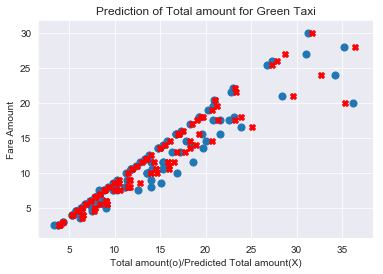

In [319]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(green["total_amount"],green["fare_amount"],s=50)
plt.scatter(green["predicted Total Amount"],green["fare_amount"],marker="X",color="red")
plt.xlabel("Total amount(o)/Predicted Total amount(X)")
plt.ylabel("Fare Amount")
plt.title("Prediction of Total amount for Green Taxi")
plt.show()

In [316]:
from statsmodels.tools.eval_measures import rmse
rmse1 = rmse(green["total_amount"], green['predicted Total Amount'])
round(rmse1,2)

0.83

In [317]:
X1 = yellow[['fare_amount','improvement_surcharge','trip_distance','tip_amount','tolls_amount']]
Y1=yellow["total_amount"]
model1 = sm.OLS(Y1, X1).fit() 
yellow['predicted Total Amount'] = round(model1.predict(X),2)
print_model1 = model1.summary()
print(print_model1)

                                 OLS Regression Results                                
Dep. Variable:           total_amount   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              7511.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):                   7.91e-143
Time:                        21:34:36   Log-Likelihood:                         -190.10
No. Observations:                 120   AIC:                                      390.2
Df Residuals:                     115   BIC:                                      404.1
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [178]:
rmse = rmse(yellow["total_amount"], yellow['predicted Total Amount'])
round(rmse,2)

15.51

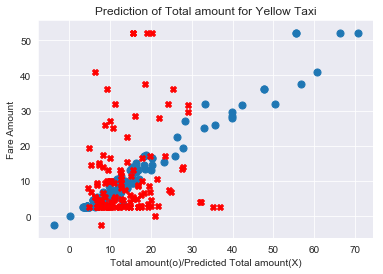

In [320]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(yellow["total_amount"],yellow["fare_amount"],s=50)
plt.scatter(yellow["predicted Total Amount"],yellow["fare_amount"],marker="X",color="red")
plt.xlabel("Total amount(o)/Predicted Total amount(X)")
plt.ylabel("Fare Amount")
plt.title("Prediction of Total amount for Yellow Taxi")
plt.show()

In [263]:
green['VendorIDBoolean']= green['VendorID']
green.VendorIDBoolean = green.VendorIDBoolean.astype('category')
green.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,TaxiType,predicted Total Amount,VendorIDBoolean,PredictedVendorIDBoolean
0,2,2018-12-21 15:17:29,2018-12-21 15:18:57,N,1,264,264,5,0.00,3.0,...,NaN,0.3,4.30,2,1,NaN,0,4.33,2,0
1,2,2019-01-01 00:10:16,2019-01-01 00:16:32,N,1,97,49,2,0.86,6.0,...,NaN,0.3,7.30,2,1,NaN,0,7.37,2,0
2,2,2019-01-01 00:27:11,2019-01-01 00:31:38,N,1,49,189,2,0.66,4.5,...,NaN,0.3,5.80,1,1,NaN,0,5.87,2,0
3,2,2019-01-01 00:46:20,2019-01-01 01:04:54,N,1,189,17,2,2.68,13.5,...,NaN,0.3,19.71,1,1,NaN,0,18.26,2,0
4,2,2019-01-01 00:19:06,2019-01-01 00:39:43,N,1,82,258,1,4.53,18.0,...,NaN,0.3,19.30,2,1,NaN,0,19.54,2,0


In [323]:
from sklearn.tree import DecisionTreeClassifier 
X1=green[['fare_amount','improvement_surcharge','trip_distance','tip_amount','tolls_amount',"total_amount"]]
y1=green['VendorIDBoolean']
clf = DecisionTreeClassifier()
clf = clf.fit(X1,y1)

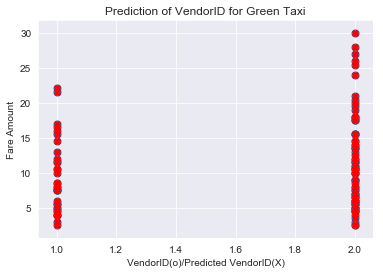

In [324]:
plt.scatter(green["VendorIDBoolean"],green["fare_amount"],s=50)
plt.scatter(green["PredictedVendorIDBoolean"],green["fare_amount"],color="red",marker='X')
plt.xlabel("VendorID(o)/Predicted VendorID(X)")
plt.ylabel("Fare Amount")
plt.title("Prediction of VendorID for Green Taxi")
plt.show()

In [301]:
from sklearn import metrics
green['PredictedVendorIDBoolean'] = clf.predict(X1)
print("Accuracy:",metrics.accuracy_score(y1, green['PredictedVendorIDBoolean']))

Accuracy: 0.9916666666666667


In [266]:
yellow['VendorIDBoolean']= yellow['VendorID']
yellow.VendorIDBoolean = yellow.VendorIDBoolean.astype('category')
yellow.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,TaxiType,predicted Total Amount,VendorIDBoolean,PredictedVendorIDBoolean
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,...,0.5,1.65,0.0,0.3,9.95,NaN,1,5.35,1,1
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,...,0.5,1.00,0.0,0.3,16.30,NaN,1,8.34,1,1
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,...,0.5,0.00,0.0,0.3,5.80,NaN,1,6.81,2,1
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,...,0.5,0.00,0.0,0.3,7.55,NaN,1,19.38,2,2
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,...,0.5,0.00,0.0,0.3,55.55,NaN,1,20.23,2,2


In [267]:
X2=yellow[['fare_amount','improvement_surcharge','trip_distance','tip_amount','tolls_amount',"total_amount"]]
y2=yellow['VendorIDBoolean']
X_test= yellow['VendorIDBoolean']
clf2 = DecisionTreeClassifier()
clf2 = clf2.fit(X2,y2)

In [268]:
yellow['PredictedVendorIDBoolean'] = clf2.predict(X2)
print("Accuracy:",metrics.accuracy_score(y2, yellow['PredictedVendorIDBoolean']))

Accuracy: 0.9416666666666667


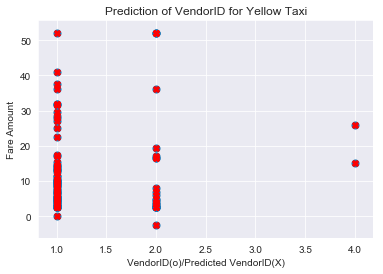

In [325]:
plt.scatter(yellow["VendorIDBoolean"],yellow["fare_amount"],s=50)
plt.scatter(yellow["PredictedVendorIDBoolean"],yellow["fare_amount"],color="red",marker='X')
plt.xlabel("VendorID(o)/Predicted VendorID(X)")
plt.ylabel("Fare Amount")
plt.title("Prediction of VendorID for Yellow Taxi")
plt.show()

In [273]:
green.corr()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,predicted Total Amount,PredictedVendorIDBoolean
VendorID,1.000000,0.060012,0.121109,-0.152584,0.198404,0.179528,0.158561,-0.262990,NaN,0.112632,0.020261,NaN,-0.060012,0.161960,-0.084559,0.060012,0.051224,0.166706,0.980505
RatecodeID,0.060012,1.000000,-0.051712,-0.133863,-0.032491,0.297045,0.146957,-0.104424,NaN,-0.063104,-0.017023,NaN,-1.000000,0.098255,-0.091765,1.000000,-0.033517,0.100491,0.061205
PULocationID,0.121109,-0.051712,1.000000,0.018663,0.025880,0.017475,-0.021249,-0.085709,NaN,0.015399,-0.026735,NaN,0.051712,-0.023762,0.006965,-0.051712,-0.041637,-0.018180,0.082571
DOLocationID,-0.152584,-0.133863,0.018663,1.000000,0.140353,0.074273,0.042928,0.304206,NaN,0.013274,0.056059,NaN,0.133863,0.074542,0.080775,-0.133863,0.199278,0.053934,-0.182436
passenger_count,0.198404,-0.032491,0.025880,0.140353,1.000000,-0.006358,-0.005620,-0.010685,NaN,0.040737,-0.065817,NaN,0.032491,-0.005270,-0.026374,-0.032491,0.020378,-0.007563,0.136537
trip_distance,0.179528,0.297045,0.017475,0.074273,-0.006358,1.000000,0.929475,-0.098216,NaN,0.119874,0.317025,NaN,-0.297045,0.893178,0.038120,0.297045,0.233920,0.899385,0.200228
fare_amount,0.158561,0.146957,-0.021249,0.042928,-0.005620,0.929475,1.000000,-0.114719,NaN,0.144969,0.295714,NaN,-0.146957,0.954925,-0.008917,0.146957,0.231690,0.961506,0.179954
extra,-0.262990,-0.104424,-0.085709,0.304206,-0.010685,-0.098216,-0.114719,1.000000,NaN,0.090501,-0.027591,NaN,0.104424,-0.019586,-0.092761,-0.104424,0.402413,-0.085170,-0.258289
mta_tax,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tip_amount,0.112632,-0.063104,0.015399,0.013274,0.040737,0.119874,0.144969,0.090501,NaN,1.000000,0.087904,NaN,0.063104,0.349168,-0.689106,-0.063104,0.201531,0.351548,0.124189
